# Tutorial: How to Correct an Interferogram with GPS Point Displacements

This notebook will guide you through how to integrate GPS point displacements with an unwrapped interferogram. This process both helps correct long-wavelength atmospheric noise signals in your interferogram, and provides an underlying reference frame for your displacements. Additionally, the process taught here can be scaled up to correct many interferograms for a time series workflow.

If you wish to read more about the benefits of correcting InSAR interferograms with GPS displacements in a time series workflow, check out Neely et al. (2020), Xu et al. (2021), and Guns et al. (2022), for recent research using this type of workflow (full references at end). The interferogram used in this example comes from a time series prepared by Katherine Guns to study the 2019 Ridgecrest earthquake sequence in eastern California, USA (see Guns et al. (2022) for processing details). 

##### We break this process up into the following steps:

(1) Obtaining GPS displacement data for the area of the interferogram

(2) Preparing GPS data for the integration process -- avoiding GPS data noise

(3) Converting GPS East/North/Up displacements into Line-Of-Sight (LOS)

(4) Correcting the InSAR interferogram

#### This same process can also be used to correct an InSAR velocity field produced from a time series analysis, but with GPS velocities, instead of displacements. We provide a short description of how the process differs. 

## (1) Obtaining GPS displacement data for the area of the interferogram

There are several different GPS data repositories and analysis centers operating in North America. For this example we will be using data from the Scripps Orbit and Permanent Array Center (SOPAC) displacement time series archive (http://sopac-csrc.ucsd.edu/index.php/displacements/ ). In particular we will be using the NASA MEaSUREs project Extended Solid Earth Science ESDR System "ESESES" Combination coordinate time series product, which is a combination of both NASA-JPL time series and SOPAC time series. We choose this time series because of its quality control on offsets and unknown transient features in the time series. To see what stations are available for this product we go to MGViz: http://mgviz.ucsd.edu/?mission=ESESES 

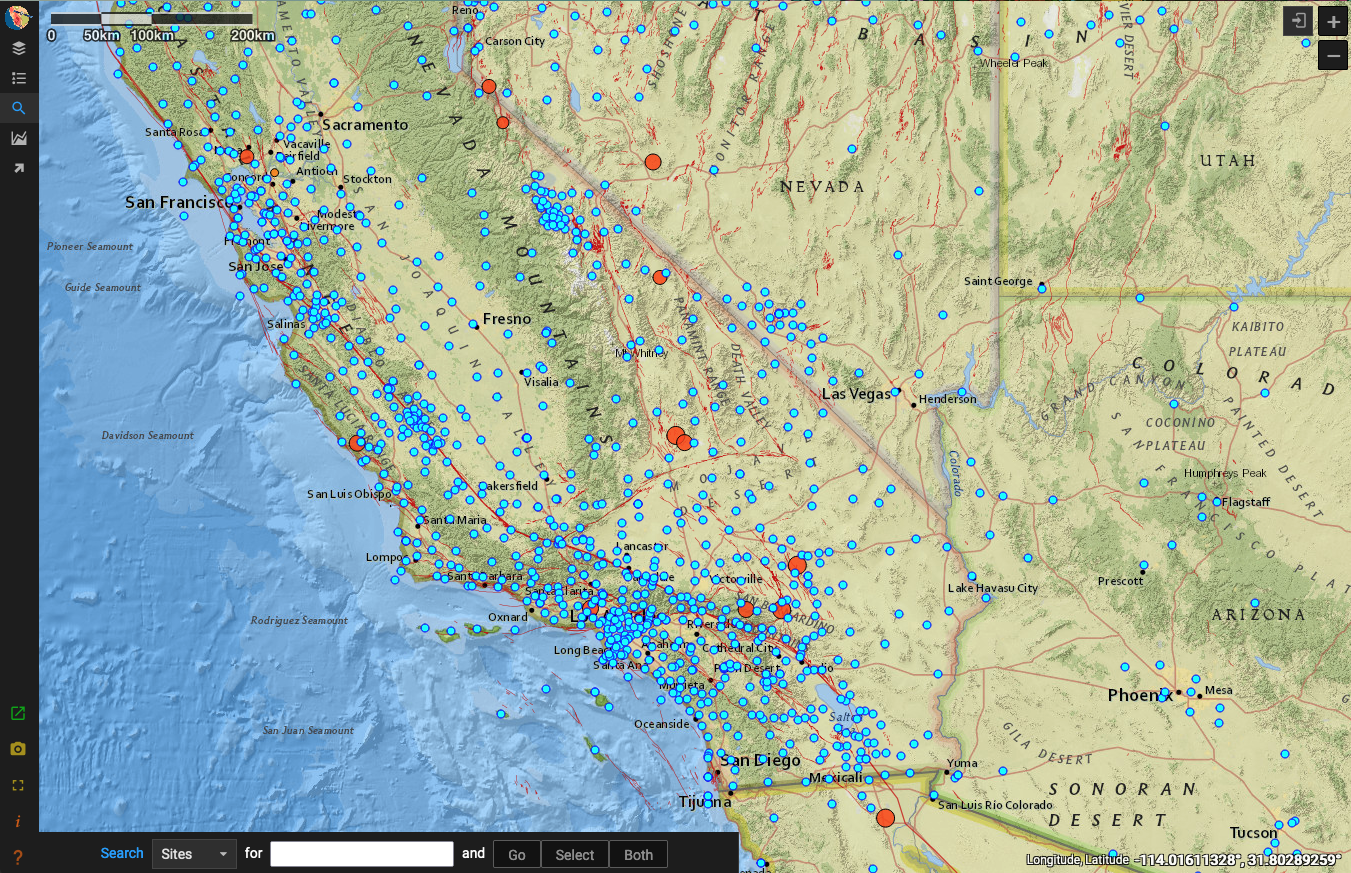



From here, we can see we have great coverage of eastern California. We can see what stations are nearby by clicking on any of the blue dots, to open up the time series viewer:

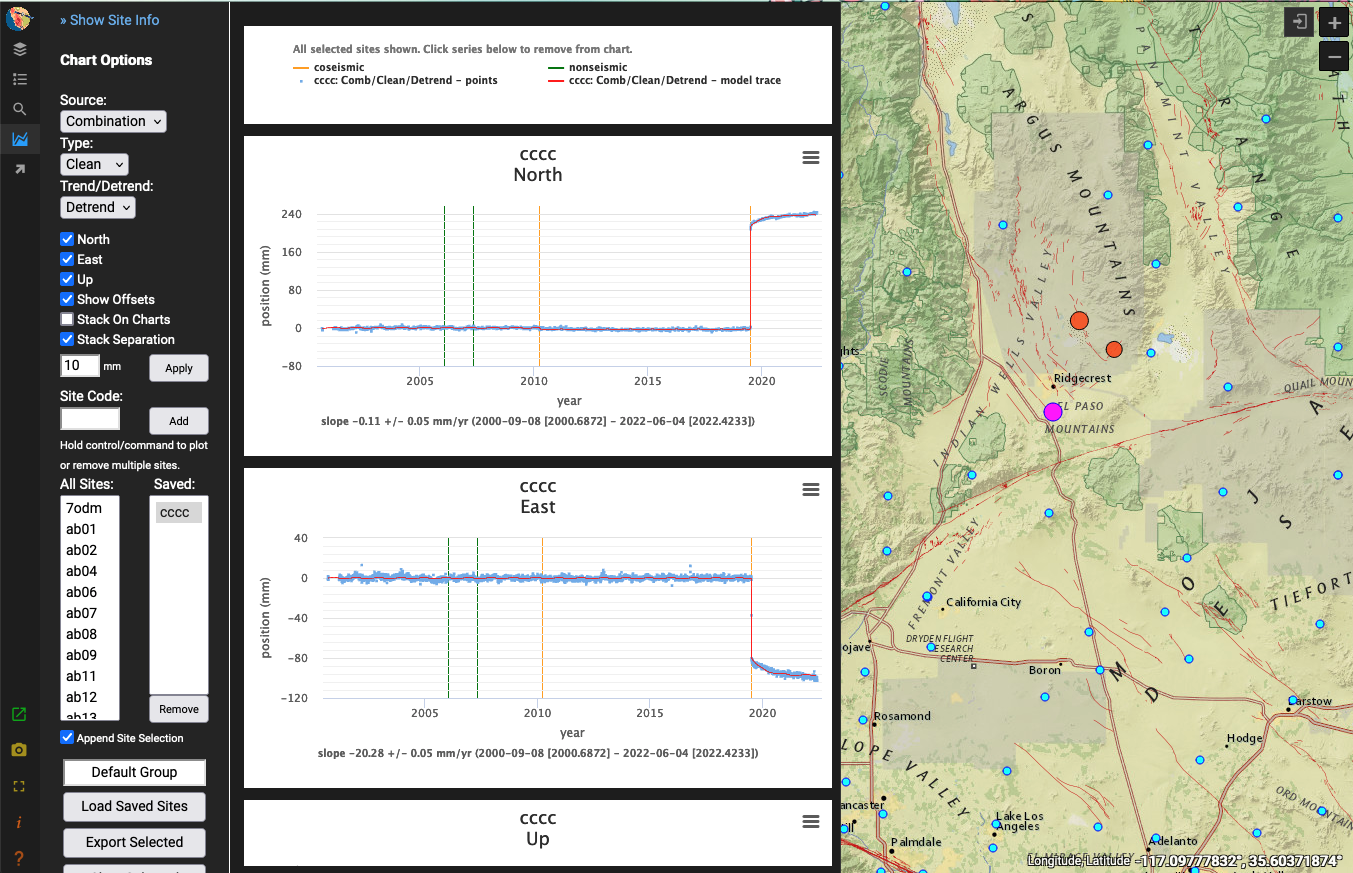





*NOTE: If you are trying to apply this process to your own interferogram(s), do check out the Nevada Geodetic Laboratory Archive as they may have additional GPS station locations compared to the MEaSUREs ESESES project, especially internationally (see http://geodesy.unr.edu/NGLStationPages/gpsnetmap/GPSNetMap.html )*


Next, we need to actually download the displacement time series data we want. To do this, we visit:

http://sopac-csrc.ucsd.edu/index.php/displacements/

And click on the "Western North America (WNAM)" link (if you are looking for global data, click the "Global" link)


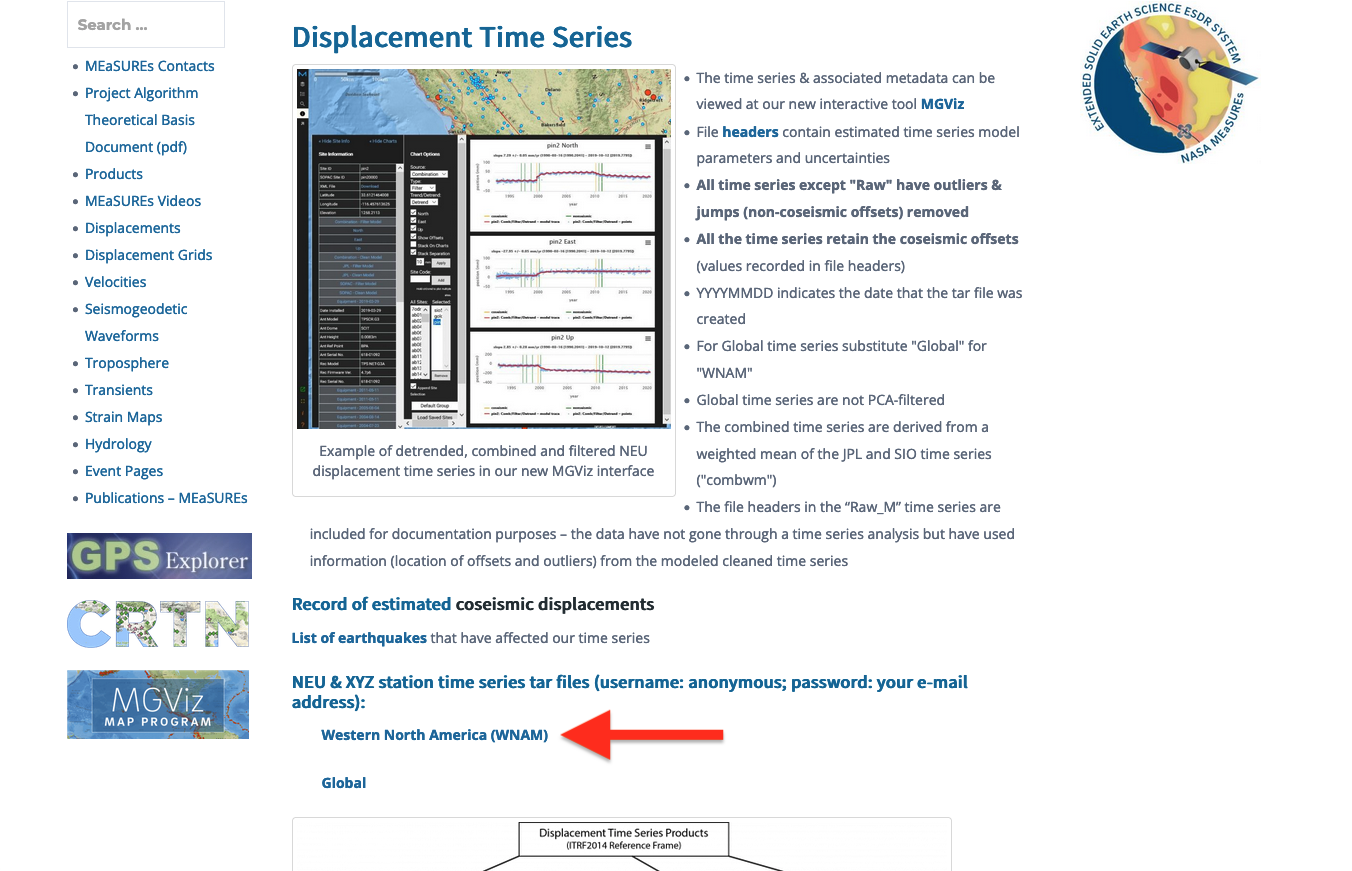

This will ask you to log in, but all you have to do is:

`username: "anonymous"`

`password: your email, e.g. "ilovegps@email.com"`


This will send you to a page that lists all available products (there are many). For this example, we are going to choose the "WNAM_Clean_TrendNeuTimeSeries_comb" product (highlighted with an arrow here). Note that every week these files are updated with new YYYYMMDD dates as new data is processed and added each week, so the dates you see may differ from this example.

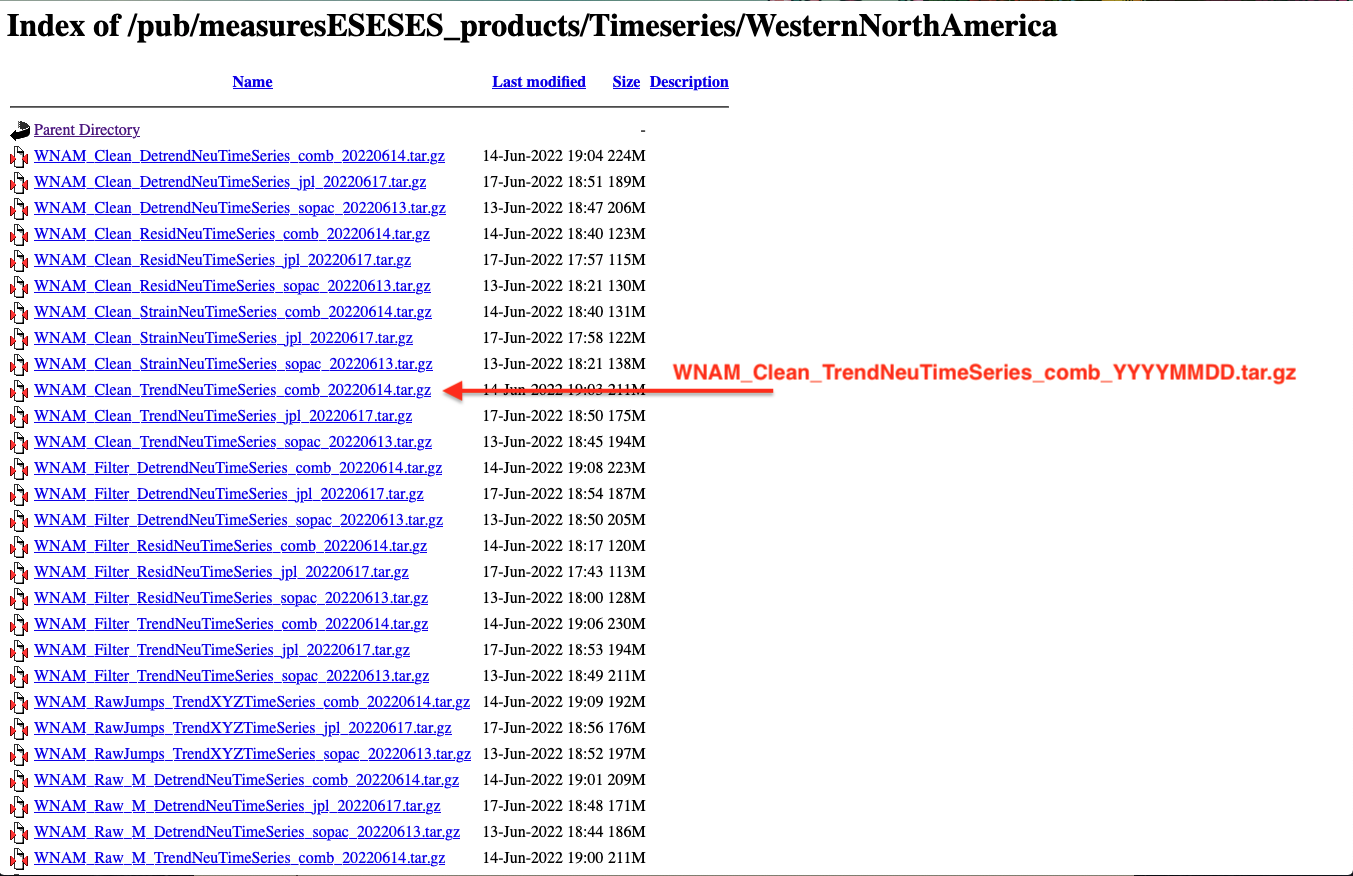

Now you have a tar file of all the displacement time series for all the stations in Western North America processed by NASA-JPL and SOPAC. What we need to do next is select the stations inside our region of interest. One can do this using the map to select the four letter station codes that fall within the approximate area of your interferogram.

If we expand the tar file, and list the first ten files inside, we can see that there are many stations compressed as *.Z zip files, for example: 

In [1]:
import os

! ls WNAM_Clean_TrendNeuTimeSeries_comb_20220614/ | head -10

7odmCleanTrend.neu.Z
ab01CleanTrend.neu.Z
ab02CleanTrend.neu.Z
ab06CleanTrend.neu.Z
ab07CleanTrend.neu.Z
ab08CleanTrend.neu.Z
ab09CleanTrend.neu.Z
ab11CleanTrend.neu.Z
ab12CleanTrend.neu.Z
ab13CleanTrend.neu.Z


In fact, if we list how many stations are inside this file, we can clearly see there are way more stations than we need for our interferogram area!

In [2]:
import os

! ls WNAM_Clean_TrendNeuTimeSeries_comb_20220614/ | wc -l

    1847


At this point, we choose the stations we want to include, and unzip those specific sites. For this particular interferogram, we will be using 62 GNSS stations, which we select based on their proximity to the earthquake epicenter (and their location within the boundary of the interferogram). A quick way to compare this is to plot your interferogram in GoogleEarth so you can observe its exact geocoded coverage. Also, double check that the stations you want to use have temporal coverage around your interferogram time, as sometimes there are data gaps in GPS time series.

*Note: If you interferogram is covering a large area, we would suggest writing a short script that searches for stations within a give latitude/longtitude box to make your life easier*

## (2) Preparing GPS data for the integration process

Once you have a downloaded GPS time series, the next step you need to take is to calculate the amount of displacement that occurred at each station over the time period observed by your interferogram. For example, our interferogram contains displacements between July 4th, 2019 and July 16th, 2019 (12 days). So, for each station in our list, we need to calculate the amount of displacement over that same 12 day time period. 

A quick and easy way to do this, is to search for the given dates in each time series file, and subtract the north/east/up displacements on July 4th, from the north/east/up displacements on July 16th (i.e. postEQ_displacements - preEQ_displacements). This will provide you with three displacement values for each station.


However, the one important thing that the above method does not take into account is noise processes that occur at any given GPS station. It is fine as a close approximation, but to get the best results, we strongly recommend filtering the GPS displacements before and after the event (or use a time series model fit) to ensure that any day-to-day variations are excluded (and that we get the main displacement signal and not extra noise).

*Note: In this example, we have used a 7-day median-filtered time series and have interpolated the displacements for the specific days. By using a median filter on the week before and week after the earthquake, we are able to avoid the worst of the day-to-day variations present in the GPS time series.*

## (3) Converting GPS East/North/Up displacements into Line-Of-Sight (LOS)

The next step, once you have your displacements estimated from your GPS time series, is to convert those east/north/up displacements into Line-Of-Sight (LOS), so that they can be combined with the InSAR displacements. GMTSAR currently has a tool that accomplishes this step, called `gnss_enu2los.csh` Let's take a look at the usage below:

In [7]:
import os

! gnss_enu2los.csh


Usage: gnss_enu2los.csh master.PRM master.LED gnss.sllenu dem.grd

 master.PRM        -  PRM file for the master SAR image
 master.LED*       -  LED file for the master SAR image
 gnss.llenu**      -  GNSS displacements (Stat | Lon | Lat | E | N | U) in millimeters
 dem.grd           -  DEM grid file from your insar processing
 
 *Ensure you have the correct LED files listed in the master.PRM file 
  -- they must match 
 
 **Assumes the gnss.llenu file is a list of stations with a specific
 displacement value (e.g. the displacement between two insar scenes)
 per station.
 
Example: gnss_enu2los.csh master.PRM master.LED gnss_2018-2019.sllenu dem.grd 

Note: Check out correct_intf_with_gnss.csh to correct your interferogram
with GNSS data



To run this tool, we need to have (1) the master image parameter file `master.PRM` or for our case `S1_20190809_ALL_F1.PRM` (*Note: If you have processed a single interferogram pair, and not a time series, your `master.PRM` file will be the first date of your interferogram pair* ), (2) the corresponding LED file which should have a name like `S1_20190809_ALL_F1.LED`, (3) the `dem.grd` file that corresponds to the interferogram area and last, the GPS displacements organized like this:

Format: StationCode     Longitude     Latitide      East(mm)     North(mm)     Up(mm)



In [8]:
import os

! head -5 2019184_2019196.enudat

agmt -116.429380 34.594280 1.379275 1.560333 -2.078302
bepk -118.074090 35.878390 -100.598938 14.884107 -7.566902
bfsh -118.497960 35.591120 -25.428672 0.856083 -3.214024
bsry -117.011990 34.918610 1.368597 9.400589 5.340875
cccc -117.671170 35.565310 -80.400088 217.348454 15.442539



When you have all the files together and run this, it will create an output file called `gnss_los.rad` which will list all the same stations, but now they have been converted to Range/Azimuth coordinates and LOS displacements:

In [11]:
import os

! head -5 gnss_los.rad

3596.808379489 14170.157255835 -1.202353143149
48340.113495957 6017.107185626 -74.505092401862
58464.533678852 8733.717097332 -19.936454444609
18009.490954555 12337.681344582 4.112818597858
36960.691297952 8031.141991207 -63.828746568798


Now we have our GPS displacements in LOS, and we are ready to integrate them with our interferogram!

## (4) Correcting the InSAR interferogram

The methodology behind this "correction" or "integration" is that we are going to:

(1) extract point displacements from our interferogram at the same locations of our GPS stations

(2) subtract the GPS displacements (in LOS) from the InSAR displacements (in LOS) at these points (i.e. calculate the residuals between InSAR - GPS)

(3) create a surface or a grid from those residual (InSAR - GPS) displacements

(4) filter that surface through a gaussian filter with a wavelength that is approximately the same size at the average GPS station spacing present in your interferogram area -- this filtered grid is our "correction" grid

(5) Subtract that filtered residual correction grid from the original InSAR interferogram

That produces an integrated and corrected interferogram, that has additional long wavelength atmospheric noise removed (thanks to the GPS) and now has an underlying reference frame (that of the GPS displacements -- in this case, ITRF 2014). Check out Neely et al. (2020), Xu et al. (2021), and Guns et al. (2022) for recent explanations of this methodology.

Luckily, the GMTSAR distribution has a script that does this correction process for you! Let's take a look at the usage:

In [12]:
import os

! correct_insar_with_gnss.csh


Usage: correct_insar_with_gnss.csh master.PRM phase.grd gnsslos.rad filter_wavelength

 master.PRM        -  PRM file for the master SAR image
 phase.grd         -  phase file to be corrected
 gnsslos.rad       -  GNSS displacements in LOS in millimeters
 filter_wavelength -  wavelength of the filter in meters (0.5 gain)
 
Example: correct_insar_with_gnss.csh supermaster.PRM unwrap_dsamp.grd gnss_los.rad 40000 

See gnss_enu2los.csh for converting GNSS ENU displacement to LOS



To run this script, we need the master image parameter file,( `S1_20190809_ALL_F1.PRM` in our case), the unwrapped interferogram we are planning on correcting, or integrating with GNSS (`unwrap_ds328.grd` here), the gnss_los.rad file we just created in the step before, and the value we wish to use as our filter wavelength. In our case here, the average GPS station spacing is ~40 km, so we will use a filter wavelength of 40,000 m in this run.

When we run this script, multiple files are created, including two which we will highlight here: a `correction.grd` file which displays what exactly is removed from the interferogram, and the `gnss_corrected_intf.grd` grid, which is the final integrated/corrected grid.

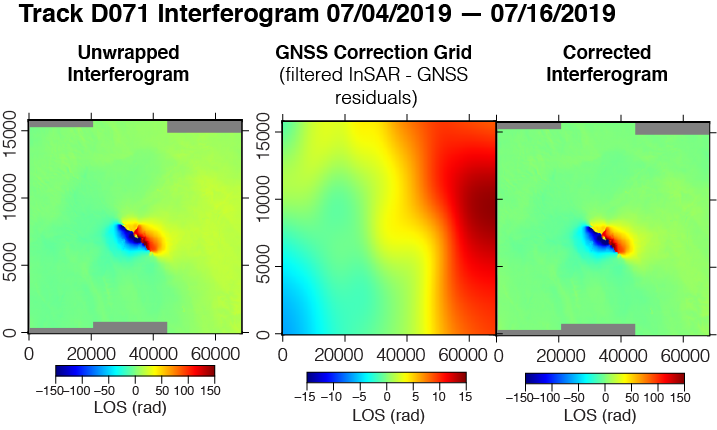


The above grid files are displayed in range/azimuth coordinates, not geocoded coordinates, but they highlight the effect caused by correcting your interferogram with GPS displacements in this way. 



### Scaling Up This Process

This process works for a single interferogram, but can also easily be scaled up for a set of interferograms for a time series workflow. All that would need to happen is to create a for loop around this process, to operate on one interferogram at a time. 



## Correcting an InSAR time series-derived velocity field with GPS velocity data

The only difference between correcting an InSAR interferogram with GPS point displacements and correcting and InSAR velocity field with GPS velocities, is you just need to obtain GPS velocity data for your chosen stations, instead of calculating displacements from their station time series. 

To do this with the time series files downloaded from the SOPAC archive (see above) you can extract the velocity of each station from the file header for each stations' time series. In addition, you can check out the prepared velocity text file from the SOPAC archive (ITRF 2014 Reference Frame): http://garner.ucsd.edu/pub/measuresESESES_products/Velocities/ESESES_Velocities_20220620.txt (you may need to enter username: "anonymous"  password: "your email" (e.g. ilovegps@email.com )

If you find that the Nevada Geodetic Laboratory has the stations you need for your area, check out their velocity file (this is in IGS 2014) here: http://geodesy.unr.edu/velocities/midas.IGS14.txt with their explanatory file here: http://geodesy.unr.edu/velocities/midas.readme.txt . They have several other more local reference frames as well, located in the righthand sidebar on this page: http://geodesy.unr.edu/index.php

Once you have assembled the velocities (east/north/up) for your chosen stations, the process from steps (3) and (4) in this document is essentially the same, except your final product will be an integrated GPS+InSAR velocity grid. 

##### Questions?

*Contact Katherine Guns kguns [at] ucsd.edu* 

#### References

Guns, K., Xu, X., Bock, Y., & Sandwell, D. (2022). GNSS-corrected InSAR displacement time-series spanning the 2019 Ridgecrest, CA earthquakes, Geophysical Journal International, Volume 230, Issue 2, September 2022, Pages 1358–1373, https://doi.org/10.1093/gji/ggac121

Neely, W.R., Borsa, A.A., and Silverii, F. (2020). "GInSAR: A cGPS Correction for Enhanced InSAR Time Series," in IEEE Transactions on Geoscience and Remote Sensing, vol. 58, no. 1, pp. 136-146, https://doi.org/10.1109/TGRS.2019.2934118.

Xu, X., Sandwell, D. T., Klein, E., & Bock, Y. (2021). Integrated Sentinel-1 InSAR and GNSS time-series along the San Andreas fault system. Journal of Geophysical Research: Solid Earth, 126, e2021JB022579. https://doi.org/10.1029/2021JB022579 

